In [8]:
import importlib
import unet

importlib.reload(unet)

from unet import UNet
from pathlib import Path
import sys
from train import SegmentationDataset
sys.path.append("..")

run_name = "20250509_182912_unetseg"
experiment_folder = Path("./runs") / run_name
model = UNet.load(experiment_folder)
model = model.to("cuda")

In [19]:
import cv2
import numpy as np
from synthetic import DataGenerator, SynthSettings

gen_settings = SynthSettings(
    downscale_factor=0.8,
    cutout_noise=True,
    cutout_noise_size=200,
    warp_noise=True,
    warp_noise_strength=5
)
generator = DataGenerator(settings=gen_settings)
_, segs, scrolls, lines = generator.generate_passages_scrolls(10, skip_char_seg=False)

# def resize(imgs: np.ndarray, factor: float):

#     height, width = imgs.shape[1:]
#     nh = int(height * factor)
#     nw = int(width * factor)

#     new_imgs = []
#     for img in imgs:
#         ri = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)
#         new_imgs.append(ri)

#     return np.stack(new_imgs)

# scrolls = resize(scrolls, factor=0.5)
# lines = resize(lines, factor=0.5)

In [ ]:
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

def inference(scrolls, segs= None, lines = None):

    track_loss = lines is not None

    if not track_loss:
        lines = np.empty((scrolls.shape[0], 0))

    data = SegmentationDataset(scrolls, segs, lines)
    criterion = nn.BCELoss()
    hats = []
    model.eval()
    test_loss = []
    with torch.no_grad():
        for batch_scrolls, batch_lines in DataLoader(data, batch_size=8):
            batch_scrolls, batch_lines = batch_scrolls.to("cuda"), batch_lines.to("cuda")
            lines_hat = model(batch_scrolls)
            out = F.sigmoid(lines_hat)
            hats.append(out.cpu().numpy())

            if track_loss:
                loss = criterion(out, batch_lines)
                print(loss.item())
                test_loss.append(loss.item())


    hats = np.concatenate(hats, axis=0)
    if track_loss:
        return hats, np.mean(test_loss)
    else:
        hats


hats, loss = inference(scrolls, segs, lines)
loss

0.02277354896068573
0.019587023183703423
0.02749459072947502
0.02554170973598957
0.019951121881604195
0.025902969762682915
0.02846798300743103
0.02517268806695938
0.034136638045310974
0.023231757804751396
0.02897161990404129
0.03643907234072685


np.float64(0.02647256028528015)

In [11]:
hats.shape

(621, 27, 52, 429)

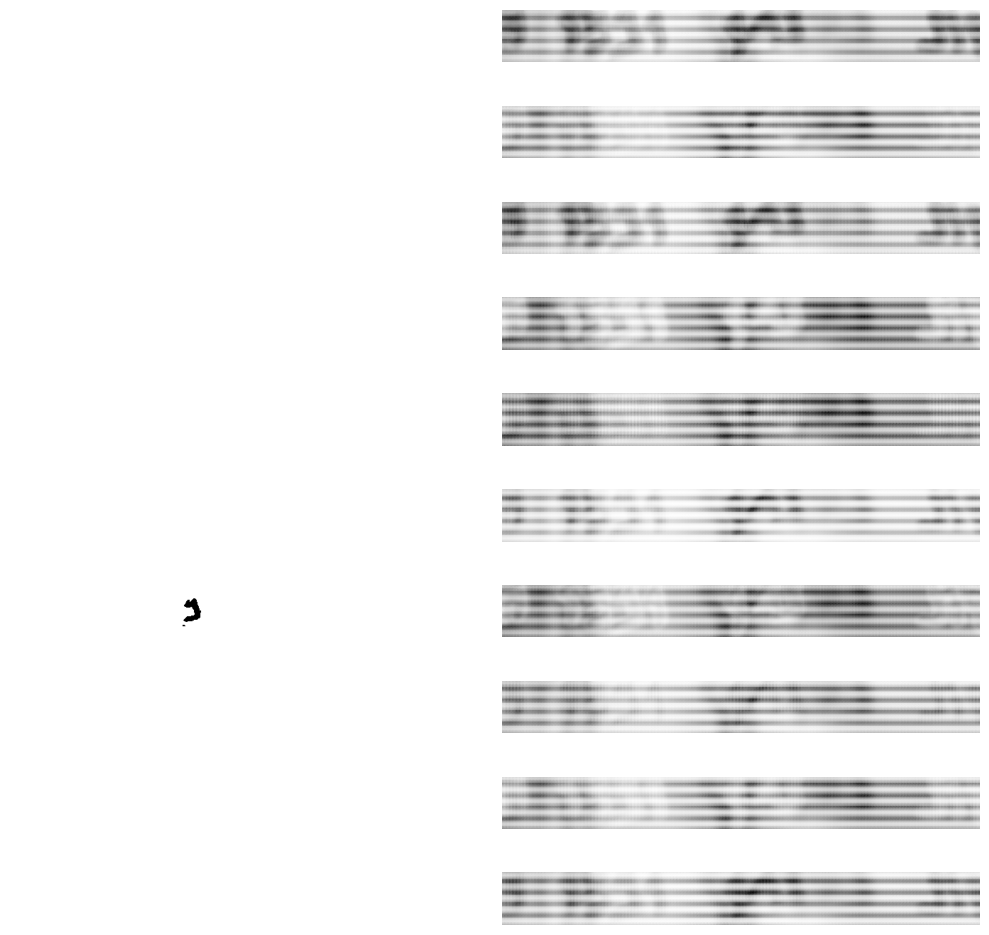

In [32]:
from matplotlib import pyplot as plt

data = SegmentationDataset(scrolls, segs, lines)

fig, ax = plt.subplots(10, 2, figsize=(10, 10))

index = np.random.choice(len(data), size=1, replace=False)[0]
seg_inds = np.random.choice(27, size=10, replace=False)

_, truth = data[index]
hat = hats[index]

for i, seg_i in enumerate(seg_inds):

    ax[i, 0].imshow(truth[seg_i], cmap="binary")
    ax[i, 1].imshow(hat[seg_i], cmap="binary")

    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()


fig.tight_layout()
plt.show()


In [39]:
crit = nn.BCELoss()
h = torch.tensor(hat).to(torch.float)
crit(truth, h)

tensor(1.1122)